In [93]:
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Exercise 5: Probabilistic inversion

We have data from ground penetrating radar (GPR) experiment.
There are 6 sources and 6 receivers, therefore 36 observations.
Forward operator in this case is a matrix acting on slowness field defined on a grid.
The result is vector of 36 observations.

In [19]:
# Load matlab data to python
data = sio.loadmat('data.mat')
Forward = data['A'] # forward operator
data_observed = data['dataobs5'] # 5th obsrvation data set
N_data = 36 #number of observations (6 receivers x 6 sources)

Domain is 6 m deep x 4 m wide.
We discretize it into 0.1 m x 0.1 m cells

In [20]:
nx = 40
ny = 60

We assume there are 4 layers, each layer has a different porosity:
* 0 - 2 m
* 2 - 3 m
* 3 - 5 m
* 5 - 6 m

Hence corresponding indices:

In [21]:
l1 = 20
l2 = 30
l3 = 50
l4 = 60

Slowness field can be calculated from porosities in the following way.

CRIM equation under saturated conditions:
$$\sqrt{\kappa} = (1-\phi)\sqrt{\kappa_s}+\phi\sqrt{\kappa_w}$$
* $\kappa$ efective relative permittivity
* $\kappa_s=5$ relative permittivity of the grains
* $\kappa_w=81$ relative permittivity of water
* $\phi$ porosity

$s=\frac{\sqrt{\kappa}}{c}$
* $c=0.3$ (m/ns), speed of light
* $s$, slowness

In [29]:
kappa_s = 5 # relative permittivity of the grains
kappa_w = 81 # relative permittivity of water
c = 0.3 # speed of light in m/ns

def slowness(porosity):
    """
    Slowness in CRIM model
    c is constant, speed of light
    :param porosity: porosity
    :return : slowness in ns/m
    """
    return ((1-porosity)*np.sqrt(kappa_s)+porosity*np.sqrt(kappa_w))/c

We make a prior assumption that porosities have uniform distribution between 0.2 and 0.4.

In [97]:
def random_porosity(n):
    """
    Returns random number between 0.2, 0.4
    :param n: size of output random vector
    :return : uniform random vector of size n in [0.2, 0.4]
    """
    return np.random.uniform(low=0.2, high=0.4, size=n)

## Rejection sampling

We will compute porosities distribution using rejection sampling.

Likelihood function ($d_0$ are observed data and $d$ simulated data):
$$L(m|d) = \left(\frac{1}{\sqrt{2\pi}\sigma}\right)^N \exp\left(-\frac{1}{2}\frac{||d-d_0||^2}{\sigma^2}\right)$$
Supremum of likelihood function:
$$S_L = \left(\frac{1}{\sqrt{2\pi}\sigma}\right)^N \exp\left(-0.5N\right)$$
In this case:
* we assume that error is known ($\sigma=1$ ns)
* number of observations $N=36$

In [98]:
sigma = 1 # standard deviation
def likelihood(d, d0):
    """
    Likelihood function.
    :param d: simulated data vector
    :param d0: observed data vector
    :return : likelihood function
    """
    return (1/(np.sqrt(2*np.pi)*sigma))**N_data * np.exp(-0.5*np.sum((d-d0)*(d-d0))/sigma**2)

sup_likelihood = (1/(np.sqrt(2*np.pi)*sigma))**N_data * np.exp(-0.5*N_data)

The rejection sampling algorithm for this specific problem is implemented as follows

In [99]:
def rejection_sampling_solution(nsamples):
    """
    :param nsamples: number of samples
    :return : 2d numpy array of sampled porosities for 4 layers
    """
    porosities_list = []
    porosity = np.zeros((nx, ny))
    for i in np.arange(nsamples):
        p = random_porosity(4)
        porosity[0:nx, 0:l1] =  p[0]
        porosity[0:nx, l1:l2] = p[1]
        porosity[0:nx, l2:l3] = p[2]
        porosity[0:nx, l3:l4] = p[3]
        data_sim = Forward.dot(slowness(porosity).flatten('F'))
        if np.random.uniform(0,1,1) < likelihood(data_sim, data_observed.flatten())/sup_likelihood :
            porosities_list.append(p)
    return np.vstack(porosities_list)

We need a lot of samples in order to get rather poor statistics.

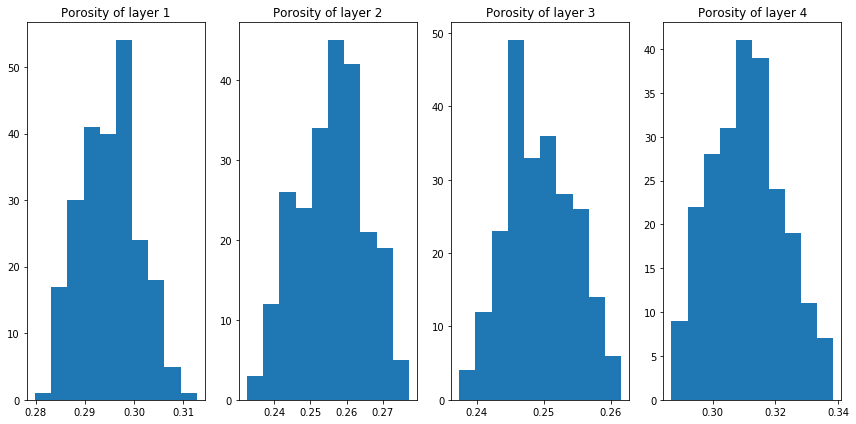

In [101]:
Porosities = rejection_sampling_solution(1e6)
fig, axes = plt.subplots(ncols=4, figsize=(12,6))
i = 0
for ax in axes:
    ax.set_title('Porosity of layer ' + str(i+1))
    ax.hist(Porosities[:,i], 10)
    i += 1
fig.tight_layout()